# USP Datasets

Data presented in Souza et al. 2020 [1], mainly used for benchmarking stream learning algorithms. The datasets are available in the `arff` format.

The datasets represent various classification tasks with different characteristics, such as class imbalance, concept drift, and noise.
Nevertheless, the information about concept drift is not exposed in the data, making evaluation challenging.

Paper presents 11 new real-world datasets (INSECTS), where changes are controllled and known. Following image illustrates the pattern changes in individual datasets, according to matching name.

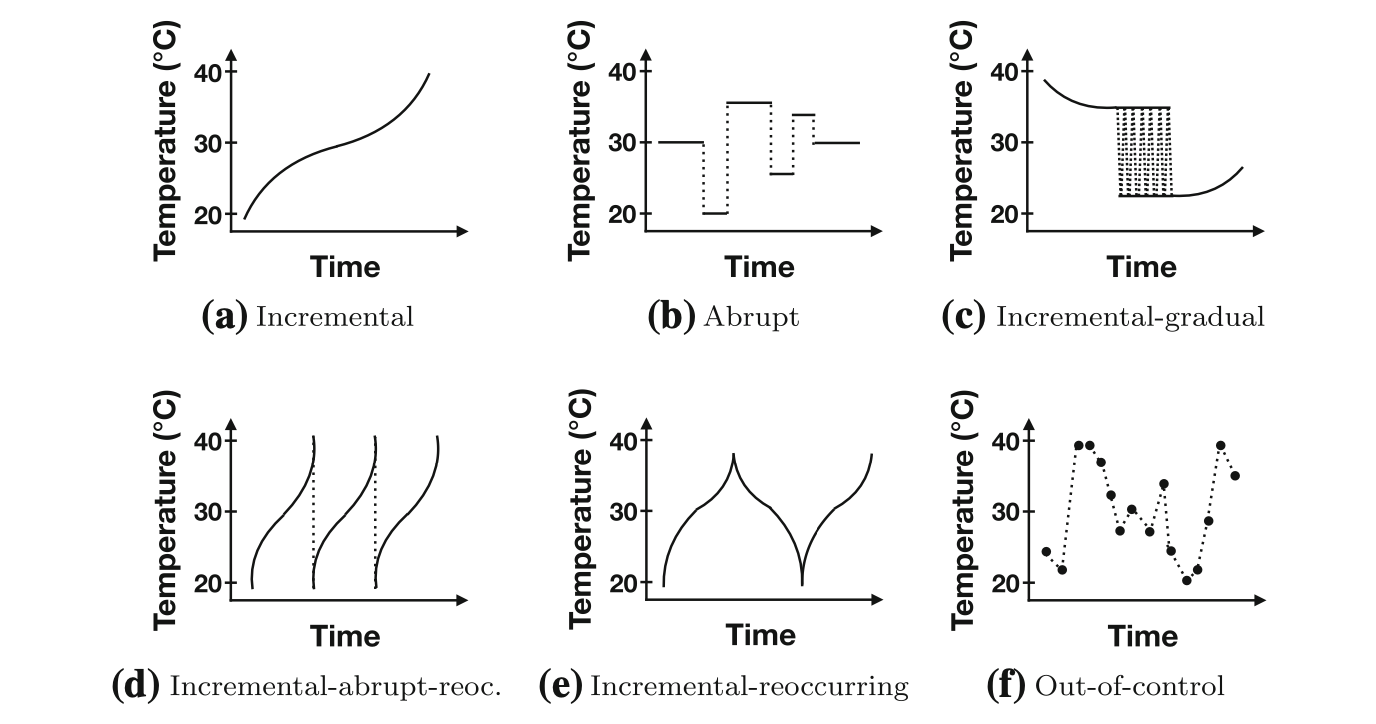

Moreover, the publication include table with instances of the datasets, where changes were introduced. The table is captured in dictionary below.

[1] Souza, V.M.A., dos Reis, D.M., Maletzke, A.G. et al. Challenges in benchmarking stream learning algorithms with real-world data. Data Min Knowl Disc 34, 1805–1858 (2020). https://doi.org/10.1007/s10618-020-00698-5

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from river.decomposition import OnlineDMD
from river.preprocessing import Hankelizer
from river.utils import Rolling
from tqdm import tqdm

sys.path.append("../")

from functions.chdsubid import SubIDChangeDetector, get_default_params
from functions.datasets import load_usp

Rolling.learn_one = Rolling.update  # type: ignore

In [ ]:
change_points: dict[str, list | None] = {
    "INSECTS-incremental_balanced_norm": None,
    "INSECTS-incremental_imbalanced_norm": None,
    "INSECTS-abrupt_balanced_norm": [14352, 19500, 33240, 38682, 39510],
    "INSECTS-abrupt_imbalanced_norm": [83859, 128651, 182320, 242883, 268380],
    "INSECTS-gradual_balanced_norm": [14028],
    "INSECTS-gradual_imbalanced_norm": [58159],
    "INSECTS-incremental-abrupt_balanced_norm": [26568, 53364],
    "INSECTS-incremental-abrupt_imbalanced_norm": [150683, 301365],
    "INSECTS-incremental-reoccurring_balanced_norm": [26568, 53364],
    "INSECTS-incremental-reoccurring_imbalanced_norm": [150683, 301365],
    "INSECTS-out-of-control_norm": None,
}

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
dfs = load_usp()

In [7]:
print(f"{'Dataset':<48} | {'Features':>8} | {'Samples':>8} | {'Classes':>8}")
print("-" * 81)
for k, v in dfs.items():
    print(
        f"{k:<48} | {len(v.select_dtypes(include="number").columns):>8} | "
        f"{len(v):>8} | {v["class"].nunique():>8}"
    )

Dataset                                          | Features |  Samples |  Classes
---------------------------------------------------------------------------------
INSECTS-incremental-reoccurring_balanced_norm    |       34 |    79986 |        6
INSECTS-abrupt_imbalanced_norm                   |       34 |   355275 |        6
keystroke                                        |       11 |     1600 |        4
INSECTS-abrupt_balanced_norm                     |       34 |    52848 |        6
kddcup99                                         |       39 |   494021 |       23
rialto                                           |       28 |    82250 |       10
sensorstream                                     |        6 |  2219803 |       55
INSECTS-gradual_imbalanced_norm                  |       34 |   143323 |        6
covtype                                          |       55 |   581012 |        7
INSECTS-gradual_balanced_norm                    |       34 |    24150 |        6
elec            

In [8]:
dfs_ = {
    k: v.resample(f"{10 ** (len(str(len(v) // 1000)) - 1)}s").agg(
        ["min", "meian", "max"]
    )
    for k, v in dfs.items()
}

In [12]:
print(f"{'Dataset':<48} | {'Features':>8} | {'Samples':>8} | {'Classes':>8}")
print("-" * 81)
for k, v in dfs_.items():
    print(
        f"{k:<48} | {len(v.select_dtypes(include="number").columns):>8} | "
        f"{len(v):>8} | {v["class"]["median"].nunique():>8}"
    )

Dataset                                          | Features |  Samples |  Classes
---------------------------------------------------------------------------------
INSECTS-incremental-reoccurring_balanced_norm    |      102 |     7999 |        6
INSECTS-abrupt_imbalanced_norm                   |      102 |     3553 |        2
keystroke                                        |       33 |     1600 |        4
INSECTS-abrupt_balanced_norm                     |      102 |     5285 |        4
kddcup99                                         |      117 |     4941 |        5
rialto                                           |       84 |     8225 |        1
sensorstream                                     |       18 |     2220 |        5
INSECTS-gradual_imbalanced_norm                  |      102 |     1434 |        2
covtype                                          |      165 |     5811 |        7
INSECTS-gradual_balanced_norm                    |      102 |     2415 |        6
elec            

In [ ]:
# Prepare arrays for storing results
scores_datasets = {}
predicted_outlier, predicted_cp = {}, {}
true_outlier = []

# Iterate datasets
for i, (name, df) in enumerate(dfs_.items()):
    Y = df[["class"]]
    X = df.drop(columns=["class"], axis=1)

    hn, ref_size, test_size, r = get_default_params(
        X, len(X) // 100
    )

    # Initialize Hankelizer
    hn = 1
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    r = 2
    init_size = window_size
    odmd = Rolling(
        OnlineDMD(
            r=r,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )

    # Initialize Change-Point Detector
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + test_size + 1,
        threshold=0.01,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    scores_dmd = np.zeros(X.shape[0], dtype=float)
    predictions = np.zeros(X.shape[0], dtype=float)
    # Run pipeline
    for j, x in tqdm(
        enumerate(X.to_dict(orient="records")),
        total=len(X),
        mininterval=1.0,
        desc=f"Dataset {name} [{i+1}/{len(dfs_)}]",
    ):
        scores_dmd[j] = pipeline_dmd.score_one(x)
        predictions[j] = subid_dmd._drift_detected

        pipeline_dmd.learn_one(x)

    prediction = (
        pd.Series(predictions, index=X.index)
        .astype(int)
        .rolling(30)
        .max()
        .fillna(0)
    )

    prediction_cp = prediction.diff().abs()
    prediction_cp.iloc[0] = prediction.iloc[0]

    scores_datasets[name] = pd.Series(scores_dmd, index=X.index)
    predicted_outlier[name] = prediction
    predicted_cp[name] = prediction_cp

In [ ]:
# [donotremove]
fig, axs = plt.subplots(len(dfs), figsize=(10, 2 * len(dfs)))

if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for i, (ax, name) in enumerate(zip(axs, scores_datasets)):
    if not isinstance(ax, plt.Axes):
        raise ValueError("axs must be a list of plt.Axes")
    resample = 10 ** (len(str(len(dfs[name]) // 1000)) - 1)

    ax.set_title(name)
    cps = change_points.get(name)
    if cps is not None:
        if isinstance(cps, list):
            ax.vlines(
                [cp / resample for cp in cps],
                0,
                max(scores_datasets[name]),
                colors="tab:gray",
                alpha=0.5,
                linestyles="dashed",
                label="Change Point",
            )
            ax.vlines(
                [cp / resample + test_size for cp in cps],
                0,
                max(scores_datasets[name]),
                colors="tab:red",
                alpha=0.5,
                linestyles="dashed",
                label=f"Change Point + Peak Detection Delay {test_size}",
            )
    else:
        cps = (
            dfs[name]["class"]
            .astype("category")
            .cat.codes.rolling(resample)
            .max()
            .reset_index(drop=True)
        )
        axgt = ax.twinx()
        axgt.plot(  # type: ignore
            cps.reset_index(drop=True).index / resample,
            cps,
            color="tab:red",
            alpha=0.5,
            linestyle="dashed",
            label="Ground Truth",
        )
        axgt.plot(  # type: ignore
            (cps.reset_index(drop=True).index / resample) + test_size,
            cps,
            color="tab:red",
            alpha=0.5,
            linestyle="dashed",
            label="Ground Truth + Peak Detection Delay {test_size}",
        )

    ax.plot(scores_datasets[name].reset_index(drop=True), label="DMD Scores")
    ax.grid()

# Get the handles and labels for both plots
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = axgt.get_legend_handles_labels()  # type: ignore

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Plot merged legend
ax.legend(all_handles, all_labels, loc="upper left")

fig.tight_layout()